# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer

In [3]:
import lightgbm as lgbm

In [4]:
#Загрузим данные
df = pd.read_csv('/datasets/autos.csv')


In [5]:
RANDOM_STATE = 42

## Подготовка данных

In [6]:
def data_overview(data):
    display(data.head())
    display(data.info())
    print("Пропуски:", data.isna().sum())
    print("Явные дубликаты:", data.duplicated().sum())
    print('')
    colnames = data.select_dtypes('number').columns
    for name in colnames:
            data[name].plot.hist(bins = 100)
            plt.title(name)
            plt.show()
            
    print("Таблица корреляций Пирсона для всех численных переменных")
    print(data.corr(numeric_only = True))
    print('')
    print("Диаграммы рассеяния для всех численных переменных")
    
    for i in range(0,7,1):
        for j in reversed(range(0,7,1)):
            if i != j:
                data.plot.scatter(x = colnames[i], y = colnames[j])
                plt.xlabel(colnames[i])
                plt.ylabel(colnames[j])
                plt.show()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Пропуски: DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
Явные дубликаты: 4



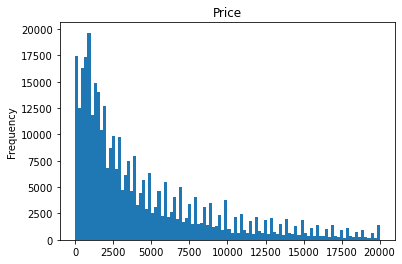

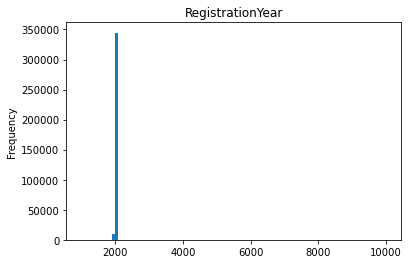

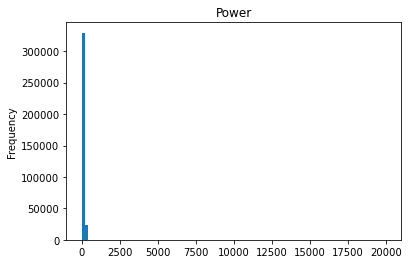

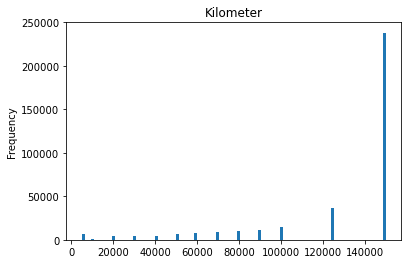

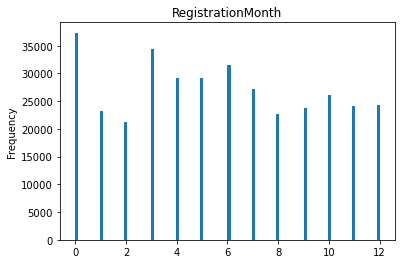

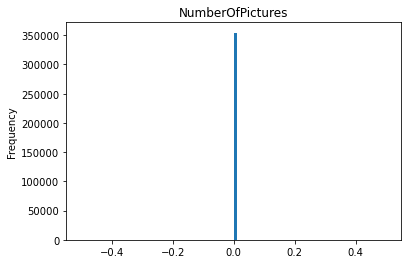

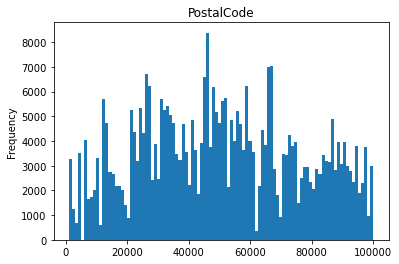

Таблица корреляций Пирсона для всех численных переменных
                      Price  RegistrationYear     Power  Kilometer   
Price              1.000000          0.026916  0.158872  -0.333199  \
RegistrationYear   0.026916          1.000000 -0.000828  -0.053447   
Power              0.158872         -0.000828  1.000000   0.024002   
Kilometer         -0.333199         -0.053447  0.024002   1.000000   
RegistrationMonth  0.110581         -0.011619  0.043380   0.009571   
NumberOfPictures        NaN               NaN       NaN        NaN   
PostalCode         0.076055         -0.003459  0.021665  -0.007698   

                   RegistrationMonth  NumberOfPictures  PostalCode  
Price                       0.110581               NaN    0.076055  
RegistrationYear           -0.011619               NaN   -0.003459  
Power                       0.043380               NaN    0.021665  
Kilometer                   0.009571               NaN   -0.007698  
RegistrationMonth           1.000000 

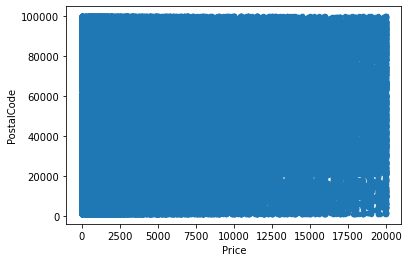

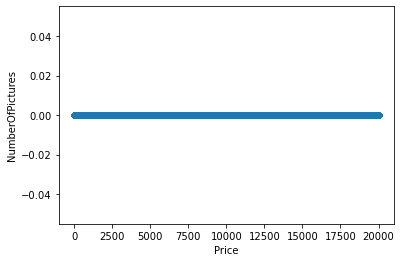

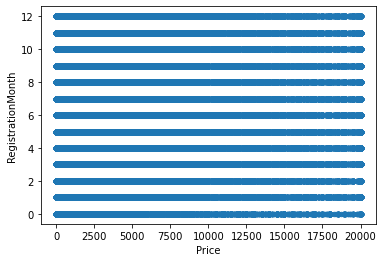

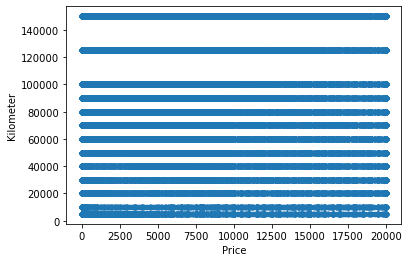

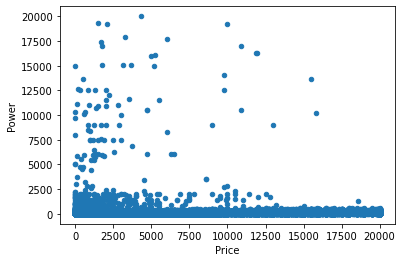

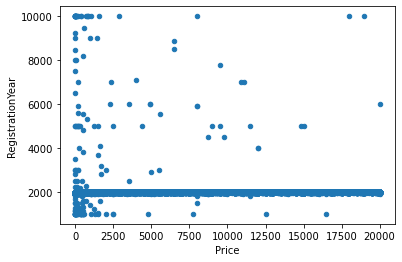

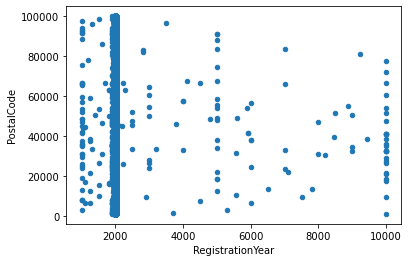

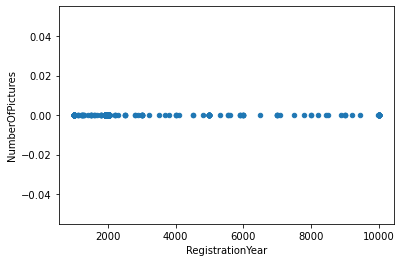

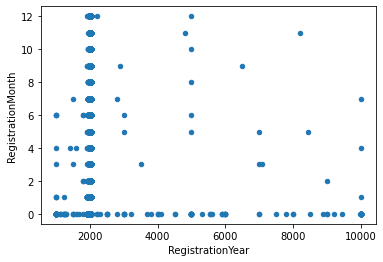

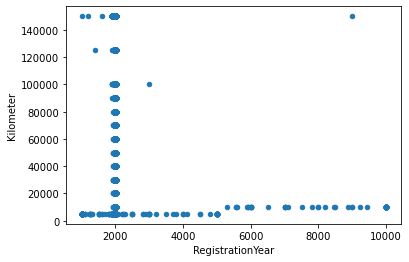

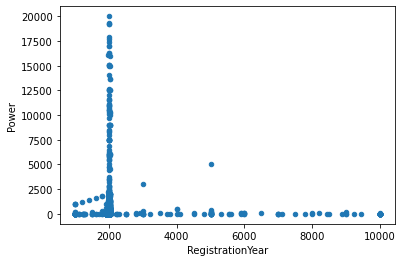

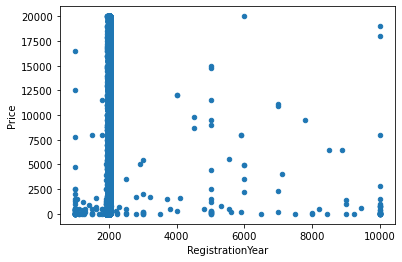

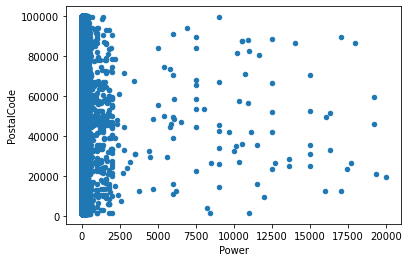

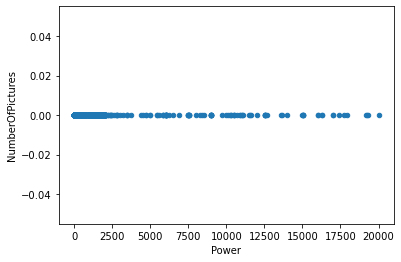

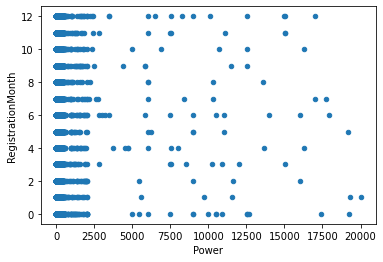

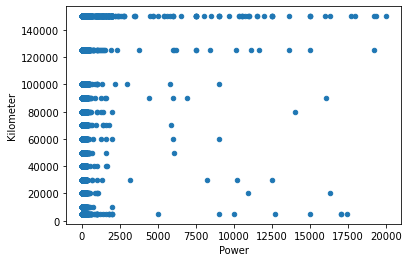

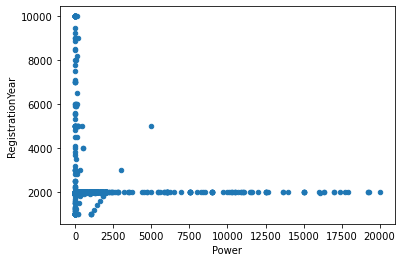

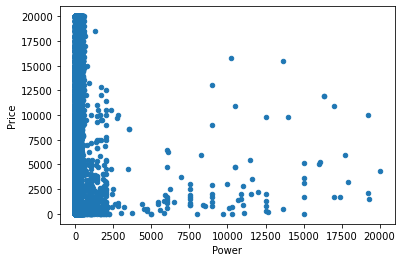

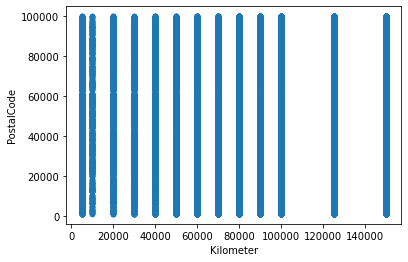

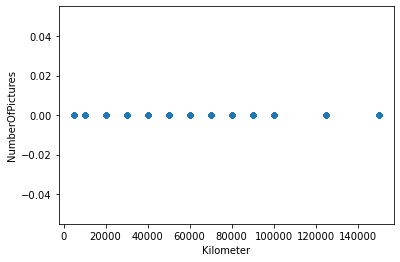

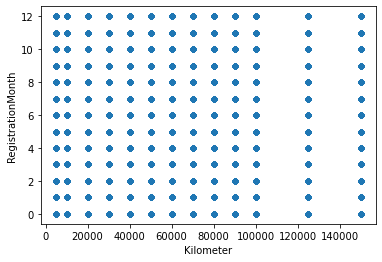

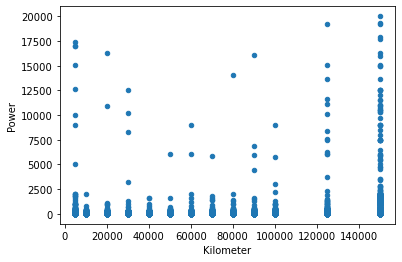

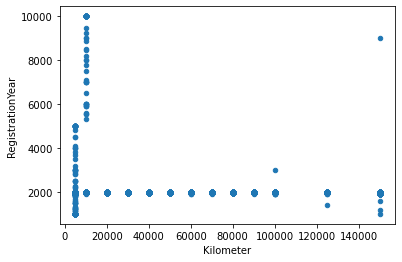

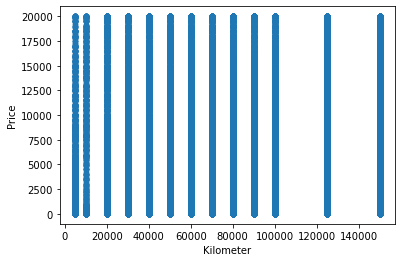

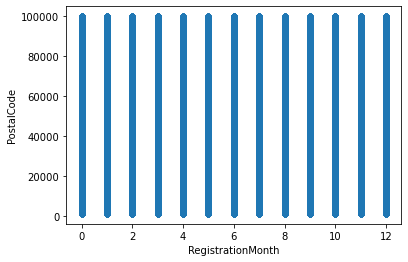

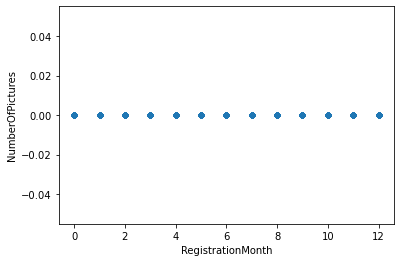

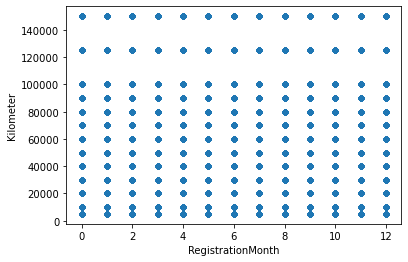

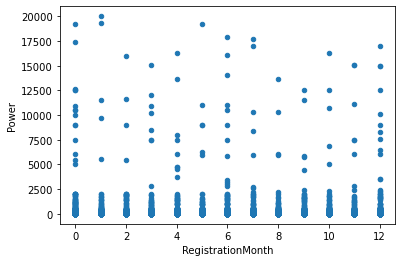

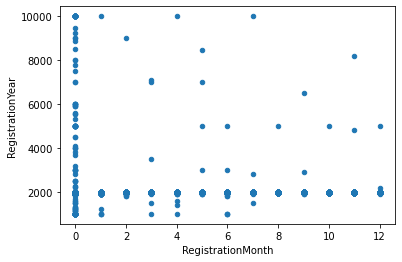

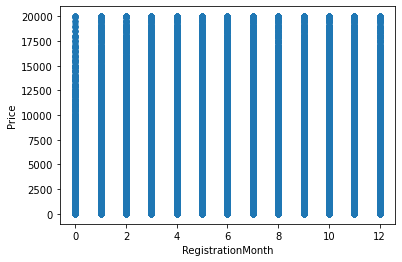

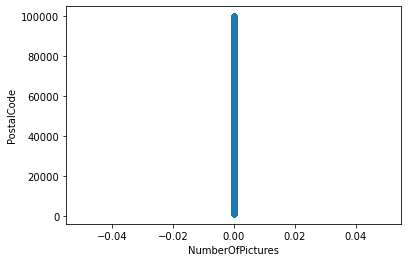

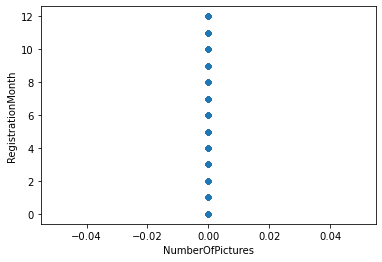

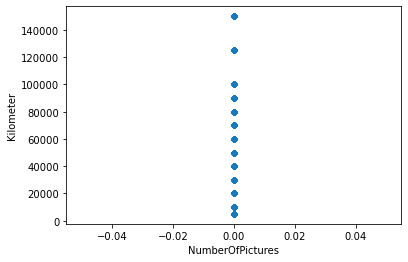

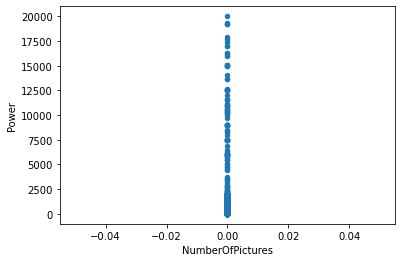

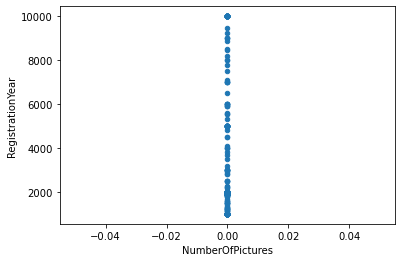

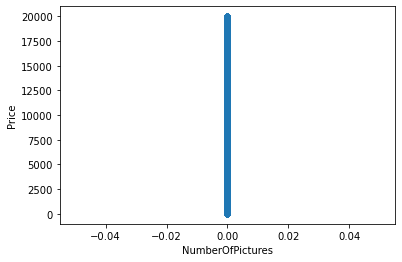

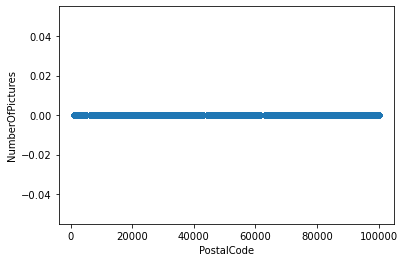

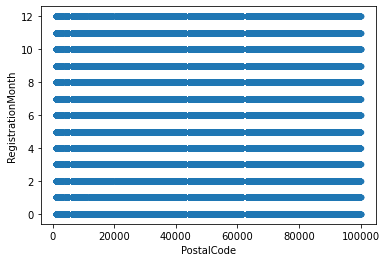

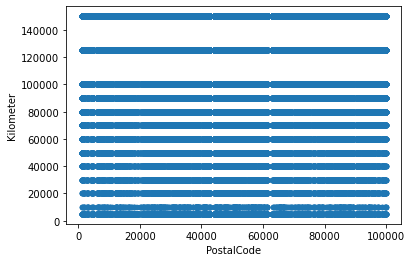

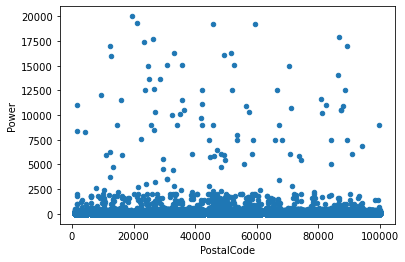

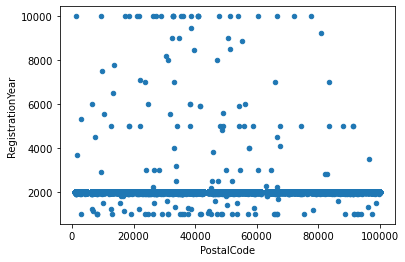

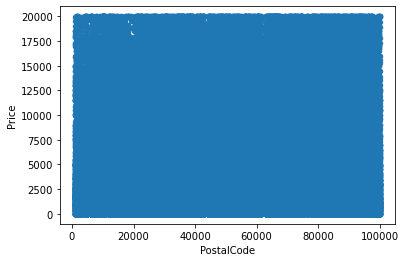

In [7]:
data_overview(df)

In [8]:
#Сохраним изначальный размер датасета, чтобы не потерять потом
df_size = df.shape

In [9]:
#Если у строки автомобиля пропусков не меньше, чем в 3 столбцах одновременна, выкинем строку
for row in range(df.shape[0]):
    count = 0
    if pd.isnull(df.loc[row, 'VehicleType']):
        count +=1
    if pd.isnull(df.loc[row, 'Gearbox']):
        count +=1
    if pd.isnull(df.loc[row, 'Model']):
        count +=1
    if pd.isnull(df.loc[row, 'FuelType']):
        count +=1
    if pd.isnull(df.loc[row, 'Repaired']):
        count +=1
    if count >= 3:
        df.loc[row, 'Discard'] = 1
    else:
        df.loc[row, 'Discard'] = 0

In [10]:
(df['Discard'].sum()/df_size[0])*100
#Такие строки составляют всего 5% данных, смело выбрасываем

5.087352449000901

In [11]:
df.drop(df[df['Discard'] == 1].index, inplace = True)
df.drop('Discard', axis = 1, inplace = True)

In [12]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          22122
RegistrationYear         0
Gearbox               8954
Power                    0
Model                12016
Kilometer                0
RegistrationMonth        0
FuelType             18540
Brand                    0
Repaired             55104
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Мы изучили данные, в них практически нет дубликатов, зато довольно много пропусков. В столбце "number of pictures" вообще как будто сплошные нули. Неожиданно много нулевых значений в столбце Power, а также есть какой-то нулевой месяц в столбце Month

Дальше заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.

**Пропуски**

- Пропуски в VehicleType и Repaired и Model заменим на 'unknown'
- Пропуски в FuelType и Gearbox заменим на наиболее часто встречающиеся (мода) по модели (Model) автомобиля



In [13]:
df['VehicleType'][df['VehicleType'].isna()] = 'unknown'
df['Repaired'][df['Repaired'].isna()] = 'unknown'
df['Model'][df['Model'].isna()] = 'unknown'

C:\Users\User\AppData\Local\Temp/ipykernel_16820/1202784777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VehicleType'][df['VehicleType'].isna()] = 'unknown'
C:\Users\User\AppData\Local\Temp/ipykernel_16820/1202784777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Repaired'][df['Repaired'].isna()] = 'unknown'
C:\Users\User\AppData\Local\Temp/ipykernel_16820/1202784777.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [14]:
#Посмотрим на столбцы FuelType и Gearbox перед тем, как заполнять пропус
df['FuelType'].unique()
#Похоже, тут есть синонимы - petrol и gasoline. Унифицируем это.
df.loc[df['FuelType'] == 'petrol','FuelType'] = 'gasoline'

In [15]:
df['Gearbox'].unique()
df['Gearbox'].isna().sum() #тут никаких сюрпризов

8954

In [16]:
#df['Model'].unique()

In [17]:
FuelType_full = df.groupby(['Model']).FuelType.apply(lambda x: x.fillna(x.mode()[0]))
df['FuelType_full'] = FuelType_full.droplevel(0)  

In [18]:
df.shape[0] - sum(df['FuelType_full'] == df['FuelType']) - df['FuelType'].isna().sum()

0

In [19]:
Gearbox_full = df.groupby(['Model']).Gearbox.apply(lambda x: x.fillna(x.mode()[0]))
df['Gearbox_full'] = Gearbox_full.droplevel(0)

In [20]:
df.shape[0] - sum(df['Gearbox_full'] == df['Gearbox']) - df['Gearbox'].isna().sum()

0

In [21]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox               8954
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             18540
Brand                    0
Repaired                 0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
FuelType_full            0
Gearbox_full             0
dtype: int64

In [22]:
df.drop(['Gearbox', 'FuelType'], axis = 1, inplace = True)

**Аномалии**

- Удалим все строки с датами до 1965 и после 2016 (год создания датасета) по столбцу RegistrationYear
- В столбце Power удалим данные со значениями меньше 20 и больше 325 (макс. значение в РФ без специального разрешения - 250)
- Предположим, что нулевой месяц - отсуствие информации о месяце регистрации автомобиля. Заменим все нулевые значения в новом столбце. Подсчитаем возраст автомобиля по столбцам RegistrationYear и RegistrationMonth и удалим их
- Посмотрим, есть ли аномальные значения в целевом признаке


In [23]:
df = df.drop(df[df.RegistrationYear > 2016].index)
df = df.drop(df[df.RegistrationYear < 1965].index)

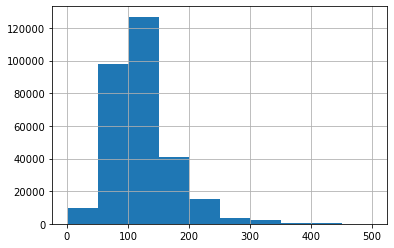

In [24]:
df['Power'].hist(range=(1, 500))
df = df.drop(df[df.Power > 325].index)
df = df.drop(df[df.Power < 20].index)

In [25]:
df['month'] = df['RegistrationMonth']
df.loc[df['month'] == 0, 'month'] = 1
df['day'] = np.ones([df.shape[0]])
df['year'] = df['RegistrationYear']

In [26]:
#Создадим единый столбец, Registration Date
df["RegistrationDate"] = pd.to_datetime(df[['year','month','day']])

In [27]:
data_date = pd.date_range(start='2016/12/31', end='2016/12/31', periods = df.shape[0])

In [28]:
data_date

DatetimeIndex(['2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31',
               ...
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31', '2016-12-31', '2016-12-31',
               '2016-12-31', '2016-12-31'],
              dtype='datetime64[ns]', length=295363, freq=None)

In [29]:
df["age"] = (data_date - df["RegistrationDate"]) // pd.Timedelta(days=365.2425)

In [30]:
df = df.drop(['RegistrationDate', 'RegistrationMonth', 'RegistrationYear', 'month', 'year', 'day'],\
             axis = 1)

--------
Теперь посмотрим на целевой признак

0


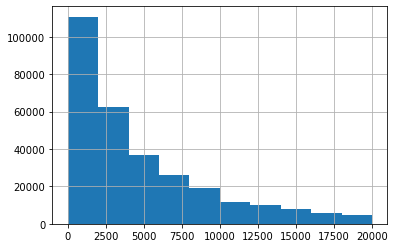

In [31]:
df['Price'].hist()
print(df['Price'].min())
df['Price'].max()

#0 автомобиль точно стоить не может, посмотрим сколько их
df.loc[df['Price'] == 0, 'Price']
#По сути эти значения можно считать пропусками,
#а так как они в целевом признаке, мы можем только их отбросить
df.drop(df[df['Price'] == 0].index, inplace = True)

<AxesSubplot:>

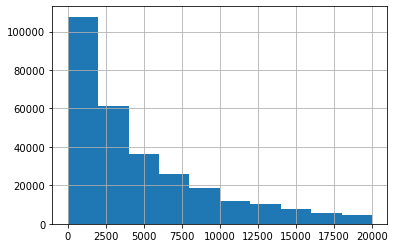

In [32]:
df['Price'].hist()

**Неиформативные столбцы**


In [33]:
df = df.drop(['NumberOfPictures','DateCrawled','DateCreated', 'LastSeen', 'PostalCode'], axis = 1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289569 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Price          289569 non-null  int64 
 1   VehicleType    289569 non-null  object
 2   Power          289569 non-null  int64 
 3   Model          289569 non-null  object
 4   Kilometer      289569 non-null  int64 
 5   Brand          289569 non-null  object
 6   Repaired       289569 non-null  object
 7   FuelType_full  289569 non-null  object
 8   Gearbox_full   289569 non-null  object
 9   age            289569 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [35]:
#Посмотрим, сколько данных мы потеряли
((df_size[0] - df.shape[0])/df_size[0])*100

#Итого мы отбросили 18% данных - немного больше, чем хотелось бы. Посмотрим на качество модели.

18.286023890351583

**Выводы по подготовке данных**:

**Пропуски**

- Пропуски в VehicleType и Repaired и Model заменили на 'unknown'
- Пропуски в FuelType и Gearbox заменили на наиболее часто встречающиеся (мода) по модели (Model) автомобиля

**Аномалии**

- Удалили все строки с датами до 1965 и после 2016 (год создания датасета) по столбцу RegistrationYear. Заменили все нулевые значения на 1, создали столбец с возрастом автомобиля, удалили столбцы RegistrationYear и RegistrationMonth
- В столбце Power удалили данные со значениями меньше 20 и больше 325 (макс. значение в РФ без специального разрешения - 250)
- Удалили строки со значением цены 0 в целевом признаке

**Неиформативные столбцы**

- Удалили столбец Number of pictures, где есть только нули
- Удалили столбцы Postal code, DateCrawled, DateCreated и LastSeen, так как они не несут дополнительной информации для стоимости машины. Мы также удалили PostalCode, так как это по сути категориальная переменная, маскирующаяся под количественную. Возможно, ее как-то все-таки можно было преобразовать, потому что расположение машины может теоретически быть связано с ее ценой (например, в хорошем районе будут машины дороже?)


**Потери данных**: После заполнения пропусков, удаления того, что не удалось заполнить и аномалий мы потеряли 18% изначального датасета.

## Обучение моделей

--------
### Подготовка категориальных признаков к задаче регрессии

In [36]:
object_features = df.select_dtypes(include=np.object).columns.tolist()

C:\Users\User\AppData\Local\Temp/ipykernel_16820/1439763794.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  object_features = df.select_dtypes(include=np.object).columns.tolist()


In [37]:
#Разделим датасет на признаки и целевой
features_gb = df.drop('Price', axis = 1) # это будут признаки для бустинга
target = df['Price']

In [38]:
#Создадим отдельный комплект признаков для линейной регрессии и дерева решений
features_sm = df.drop('Price', axis = 1) #simple models

In [39]:
# приведем категориальные признаки к формату category в датасете признаков для бустинга

features_gb[object_features] = features_gb[object_features].astype('category')

Пора делить выборки

In [40]:
X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(features_gb,target, test_size=0.4, random_state=RANDOM_STATE)
X_val_gb, X_test_gb, y_val_gb, y_test_gb = train_test_split(X_val_gb,y_val_gb, test_size=0.5, random_state=RANDOM_STATE)

In [41]:
X_train_sm, X_val_sm, y_train_sm, y_val_sm = train_test_split(features_sm,target, test_size=0.4, random_state=RANDOM_STATE)
X_val_sm, X_test_sm, y_val_sm, y_test_sm = train_test_split(X_val_sm,y_val_sm, test_size=0.5, random_state=RANDOM_STATE)

---------------------
**Преобразим объектные столбцы**

In [42]:
enc = OrdinalEncoder()
X_train_sm[object_features] = enc.fit_transform(X_train_sm[object_features])

C:\Users\User\AppData\Local\Temp/ipykernel_16820/2621897529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sm[object_features] = enc.fit_transform(X_train_sm[object_features])


In [43]:
X_val_sm[object_features] = enc.transform(X_val_sm[object_features])
X_test_sm[object_features] = enc.transform(X_test_sm[object_features])

### Обучение моделей

In [44]:
#словари параметров для гридсерчей
param_grid_dt = {'max_depth': range(1,15,5)}
param_grid_gb = {"max_depth": range(1,15,5),
    "num_leaves": range(10, 100, 10),
                'categorical_feature': object_features}
param_grid_lr = {"fit_intercept": [True] 
             }

**Простые модели**

In [45]:
%%time
lr_search = GridSearchCV(linear_model.LinearRegression(), cv = 5, param_grid = param_grid_lr, \
                         scoring = 'neg_root_mean_squared_error')
lr_search.fit(X_train_sm, y_train_sm)
lr_search.cv_results_

print('Время обучения линейной регресии:')

Время обучения линейной регресии:
Wall time: 406 ms


In [46]:
%%time
dt_search = GridSearchCV(DecisionTreeRegressor(), cv = 5, param_grid = param_grid_dt, scoring = 'neg_root_mean_squared_error')
dt_search.fit(X_train_sm, y_train_sm)
dt_search.cv_results_
print('Время обучения дерева решений:')

Время обучения дерева решений:
Wall time: 3.99 s


**Градиентный бустинг**

In [47]:
%%time
gb_search = GridSearchCV(lgbm.LGBMRegressor(random_seed=RANDOM_STATE), cv = 5, \
                         param_grid = param_grid_dt, scoring = 'neg_root_mean_squared_error')
gb_search.fit(X_train_gb, y_train_gb)
gb_search.cv_results_
print('Время обучения градиентного бустинга:')

Время обучения градиентного бустинга:
Wall time: 16.7 s


## Анализ моделей

In [48]:
%%time
lr_rmse_val = mean_squared_error(lr_search.best_estimator_.predict(X_val_sm), y_val_sm)**0.5
print('RMSE линейной регресии на валидационной выборке:', lr_rmse_val)

RMSE линейной регресии на валидационной выборке: 2923.7515912292247
Wall time: 12 ms


In [49]:
%%time
dt_rmse_val = mean_squared_error(dt_search.best_estimator_.predict(X_val_sm), y_val_sm)**0.5
print('RMSE дерева решений на валидационной выборке:', dt_rmse_val)

RMSE дерева решений на валидационной выборке: 1910.8541009443486
Wall time: 22.9 ms


In [50]:
%%time
gb_rmse_val = mean_squared_error(gb_search.best_estimator_.predict(X_val_gb), y_val_gb)**0.5
print('RMSE градиентного бустинга на валидационной выборке:', gb_rmse_val)

RMSE градиентного бустинга на валидационной выборке: 1581.7506107910272
Wall time: 259 ms


**Выводы**:
    
  Градиентный бустинг самый точный: RMSE на валидационной выборке = 1581, по сравнению с 1910 у дерева решений и 2923 у линейной регресии. При этом он работает значительно медленнее, чем простые модели, как на обучении, так и на предсказании, однако даже при этой разнице в предсказании, скорость должна быть достаточной, чтобы соотсвествовать запросу клиента. Для предсказания на тестовой выборке выберем градиентный бустинг.

In [51]:
%%time
gb_rmse_test = mean_squared_error(gb_search.best_estimator_.predict(X_test_gb), y_test_gb)**0.5
print('RMSE градиентного бустинга на тестовой выборке:', gb_rmse_test)

RMSE градиентного бустинга на тестовой выборке: 1573.0862314420328
Wall time: 248 ms
